# Intro

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.distributions.binomial as binomial

from torch.nn.functional import conv2d, max_pool2d, cross_entropy

from time import time # for time measurement

plt.rc("figure", dpi=100)

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)
print(device)

cuda:0


## Input data

In [45]:
batch_size = 100

# transform images into normalized tensors
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

train_dataset = datasets.MNIST(
    "./",
    download=True,
    train=True,
    transform=transform,
)

test_dataset = datasets.MNIST(
    "./",
    download=True,
    train=False,
    transform=transform,
)


# # Reduce train & test sets for testing the procedure
# train_dataset = torch.utils.data.Subset(train_dataset, list(range(600)))
# test_dataset = torch.utils.data.Subset(test_dataset, list(range(100)))


train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
)

## Utility functions

In [4]:
def init_weights(shape):
    # Kaiming He initialization (a good initialization is important)
    # https://arxiv.org/abs/1502.01852
    std = np.sqrt(2. / shape[0])
    w = torch.randn(size=shape, device=device) * std
    w.requires_grad = True
    
    return w


def rectify(x):
    # Rectified Linear Unit (ReLU)
    return torch.max(torch.zeros_like(x), x)


def dropout(X, p_drop=0.5):
    if not (0 < p_drop < 1): return X
    # phi = binomial.Binomial(torch.ones(X.shape), 1 - p_drop).sample()
    _, *phi_shape = X.shape # remove the first entry of X.shape in order to replace it with 1
    phi = torch.rand([1] + phi_shape, device=device)
    
    # return phi.to(device)*X / (1-p_drop)
    return (phi>p_drop)*X / (1-p_drop)


def PRelu(X, a):
    '''
    Parametric ReLU, i.e. returns a copy of 'X' where all negative entries have been
    multiplied with the corresponding entries in 'a'.
    '''
    return ((X>=0) + (X<0)*a) * X


def convolute(X, w, p_drop):
    '''
    Performs convolution, ReLU, subsampling and dropout
    '''
    conv = conv2d(X, w)
    rect = rectify(conv)
    subs = max_pool2d(rect, (2, 2))
    drop = dropout(subs, p_drop)

    return drop


class RMSprop(optim.Optimizer):
    """
    This is a reduced version of the PyTorch internal RMSprop optimizer
    It serves here as an example
    """
    def __init__(self, params, lr=1e-3, alpha=0.5, eps=1e-8):
        defaults = dict(lr=lr, alpha=alpha, eps=eps)
        super(RMSprop, self).__init__(params, defaults)

    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                grad = p.grad.data
                state = self.state[p]

                # state initialization
                if len(state) == 0:
                    state['square_avg'] = torch.zeros_like(p.data)

                square_avg = state['square_avg']
                alpha = group['alpha']

                # update running averages
                square_avg.mul_(alpha).addcmul_(grad, grad, value=1 - alpha)
                avg = square_avg.sqrt().add_(group['eps'])

                # gradient update
                p.data.addcdiv_(grad, avg, value=-group['lr'])

## Models

In [44]:
def cnn_model(x, w_c1, w_c2, w_c3, w_h2, w_a2, w_o, p_drop_input, p_drop_hidden):
    c1 = convolute(dropout(x, p_drop_input), w_c1, p_drop_hidden)
    c2 = convolute(c1, w_c2, p_drop_hidden)
    c3 = convolute(c2, w_c3, p_drop_hidden)

    c3 = c3.reshape(-1, 128)

    h2 = dropout(c3 @ w_h2, p_drop_hidden)
    a2 = PRelu(h2, w_a2)
    pre_softmax = a2 @ w_o

    return pre_softmax


# remove one convolution layer
def cnn_model_reduced(x, w_c1, w_c2, w_h2, w_a2, w_o, p_drop_input, p_drop_hidden):
    c1 = convolute(dropout(x, p_drop_input), w_c1, p_drop_hidden)
    c2 = convolute(c1, w_c2, p_drop_hidden)

    c2 = c2.reshape(-1, 1024)

    h2 = dropout(c2 @ w_h2, p_drop_hidden)
    a2 = PRelu(h2, w_a2)
    pre_softmax = a2 @ w_o

    return pre_softmax

## Time keeping

In [6]:
def time_to_str(time):
    '''
    Converts time (in seconds) to more readable format
    '''
    time = round(time)
    hours = time//3600
    minutes = (time%3600)//60
    seconds = time%60

    return f"{hours:3d}h {minutes:02d}m {seconds:02d}s"


def print_time_info(time_start, time, n_epochs, i_epoch):
    dtime = time - time_start
    print(f"Time elapsed: {time_to_str(dtime)} | Time remaining: {time_to_str((n_epochs - i_epoch - 1) * dtime / (i_epoch + 1))}")

## Running the network

Note that the training losses are skewed by dropout (since we're multiplying non-dropped inputs).

In [49]:
# stuff for keeping and estimating time
time_start = time()

p = 0.2
print(f"Running CNN model with dropout {p}")

w_c1 = init_weights((32, 1, 5, 5))
w_c2 = init_weights((64, 32, 5, 5))
# w_c3 = init_weights((128, 64, 2, 2))
# w_h2 = init_weights((128, 625))
w_h2 = init_weights((1024, 625))
w_a2 = init_weights((625,))
w_o = init_weights((625, 10))

# optimizer = RMSprop(params=[w_c1, w_c2, w_c3, w_h2, w_a2, w_o])
optimizer = RMSprop(params=[w_c1, w_c2, w_h2, w_a2, w_o])

n_epochs = 100

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        x = x.to(device)
        y = y.to(device)

        # our model requires input of dim (c x w x h)
        x = x.reshape(batch_size, 1, 28, 28)
        # feed input through model
        # noise_py_x = cnn_model(x, w_c1, w_c2, w_c3, w_h2, w_a2, w_o, p_drop_input=p, p_drop_hidden=p)
        noise_py_x = cnn_model_reduced(x, w_c1, w_c2, w_h2, w_a2, w_o, p_drop_input=p, p_drop_hidden=p)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss.to("cpu")))

        # compute the gradient
        loss.backward()

        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch

                x = x.to(device)
                y = y.to(device)
                x = x.reshape(batch_size, 1, 28, 28)

                # no dropouts for testing!
                # noise_py_x = cnn_model(x, w_c1, w_c2, w_c3, w_h2, w_a2, w_o, p_drop_input=0, p_drop_hidden=0)
                noise_py_x = cnn_model_reduced(x, w_c1, w_c2, w_h2, w_a2, w_o, p_drop_input=0, p_drop_hidden=0)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss.to("cpu")))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")
        print_time_info(time_start, time(), n_epochs, epoch)

print("\nDone!")


Running CNN model with dropout 0.2
Epoch: 0
Mean Train Loss: 1.23e+00
Mean Test Loss:  8.78e-02
Time elapsed:   0h 00m 20s | Time remaining:   0h 33m 09s
Epoch: 10
Mean Train Loss: 1.67e-01
Mean Test Loss:  5.68e-02
Time elapsed:   0h 02m 51s | Time remaining:   0h 23m 03s
Epoch: 20
Mean Train Loss: 1.56e-01
Mean Test Loss:  6.35e-02
Time elapsed:   0h 05m 22s | Time remaining:   0h 20m 11s
Epoch: 30
Mean Train Loss: 1.34e-01
Mean Test Loss:  6.88e-02
Time elapsed:   0h 07m 55s | Time remaining:   0h 17m 37s
Epoch: 40
Mean Train Loss: 1.25e-01
Mean Test Loss:  4.70e-02
Time elapsed:   0h 10m 27s | Time remaining:   0h 15m 02s
Epoch: 50
Mean Train Loss: 1.29e-01
Mean Test Loss:  5.70e-02
Time elapsed:   0h 12m 58s | Time remaining:   0h 12m 27s
Epoch: 60
Mean Train Loss: 1.32e-01
Mean Test Loss:  5.67e-02
Time elapsed:   0h 15m 29s | Time remaining:   0h 09m 54s
Epoch: 70
Mean Train Loss: 1.30e-01
Mean Test Loss:  5.12e-02
Time elapsed:   0h 17m 59s | Time remaining:   0h 07m 21s
Epoch:

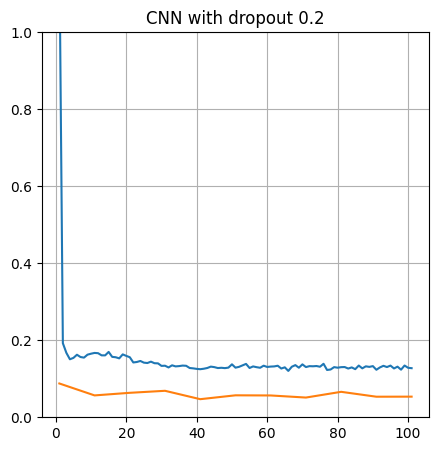

In [50]:
fig = plt.gcf()
fig.set_size_inches(5, 5)

plt.plot(np.arange(1, n_epochs + 2), train_loss, label=f"Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title(f"CNN with dropout {p}")
plt.ylim(0, 1)
plt.grid()
plt.show()

In [51]:
params = optimizer.param_groups.copy()[0]['params']

In [ ]:
# full model saved in 'optimizer'

In [52]:
for t in params:
    print(t.shape)

torch.Size([32, 1, 5, 5])
torch.Size([64, 32, 5, 5])
torch.Size([1024, 625])
torch.Size([625])
torch.Size([625, 10])


In [53]:
sample_in, sample_out = test_dataset[23]
sample_img = sample_in[0]
print(sample_out)

5


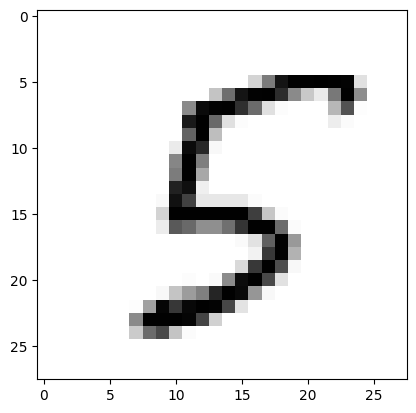

In [54]:
plt.imshow(sample_img, cmap="Greys")
plt.show()

In [55]:
filtered = convolute(sample_in.to(device), params[0], 0)

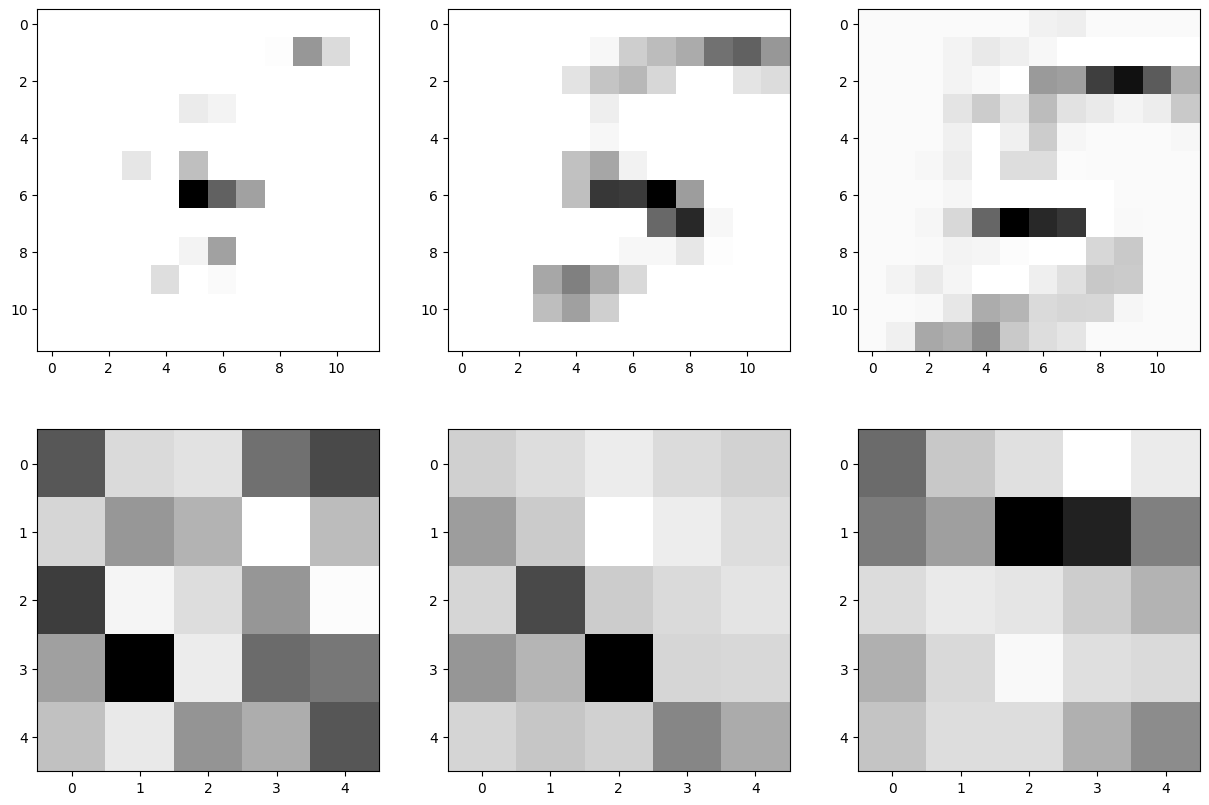

In [61]:
start_idx = 11

plt.gcf().set_size_inches(15, 10)
for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.imshow(filtered[i+start_idx].detach().to("cpu"), cmap="Greys")
    plt.subplot(2, 3, i+4)
    plt.imshow(params[0][i+start_idx][0].detach().to("cpu"), cmap="Greys")
plt.show()